In [1]:
# import necessary libraries
import os, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
def get_device():
    if torch.cuda.is_available(): return torch.device("cuda")
    return torch.device("cpu")

In [4]:
# Get CIFAR10 data
def cifar_loaders_random_labels(data_dir="./data", batch=128, workers=2):
    """
    Returns train_loader (with randomized TRAIN labels) and test_loader (unaltered).
    No augmentation; only normalization.
    """
    # Standard CIFAR-10 channel stats obtained from running previous code for HW_1_2
    mean=(0.4914,0.4822,0.4465); std=(0.2023,0.1994,0.2010)
    tf = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=tf)
    test_set  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf)

    # --- Randomize TRAIN labels only ---
    set_seed(123)  # fixed for reproducibility of the shuffle
    targets = np.array(train_set.targets)
    perm = np.random.permutation(len(targets))     # shuffle indices
    targets_shuffled = targets[perm]               # random labels per image
    train_set.targets = targets_shuffled.tolist()  # overwrite labels

    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,
                              num_workers=workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch, shuffle=False,
                              num_workers=workers, pin_memory=True)
    return train_loader, test_loader

In [5]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                           # 64x16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128,128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                           # 128x8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
    def forward(self,x): return self.classifier(self.features(x))


In [6]:
# Training and Testing
def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        tot_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

In [7]:
# Plots
def plot_curves(train_vals, test_vals, ylabel, title, out_path=None):
    plt.figure(figsize=(8,5))
    plt.plot(train_vals, label="train", linewidth=1.5)
    plt.plot(test_vals,  label="test",  linewidth=1.5)
    plt.xlabel("epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, linewidth=0.3); plt.legend()
    plt.tight_layout()
    if out_path: 
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=180)
    plt.show()
    plt.close()

In [8]:
def main(epochs=100, lr=1e-3, weight_decay=0.0, batch=128, data_dir="./data"):
    """
    Train a CNN on CIFAR-10 with RANDOMIZED TRAIN LABELS.
    Plots loss and accuracy curves (train vs test).
    """
    set_seed(42)
    dev = get_device()
    out_dir="HW_1-3_RandomLabels"
    train_loader, test_loader = cifar_loaders_random_labels(data_dir=data_dir, batch=batch)

    model = CNN().to(dev)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, dev)
        te_loss, te_acc = evaluate(model, test_loader, loss_fn, dev)

        train_losses.append(tr_loss); test_losses.append(te_loss)
        train_accs.append(tr_acc);   test_accs.append(te_acc)

    # Plots
    plot_curves(train_losses, test_losses, ylabel="loss",
                title="CIFAR-10 (Random Labels): Loss vs Epoch", 
                out_path=os.path.join(out_dir, "loss_curve.png"))
    plot_curves(train_accs, test_accs, ylabel="accuracy",
                title="CIFAR-10 (Random Labels): Accuracy vs Epoch", 
                out_path=os.path.join(out_dir, "accuracy_curve.png"))
    return model, (train_losses, test_losses, train_accs, test_accs)

Files already downloaded and verified
Files already downloaded and verified


/home/adarshn/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


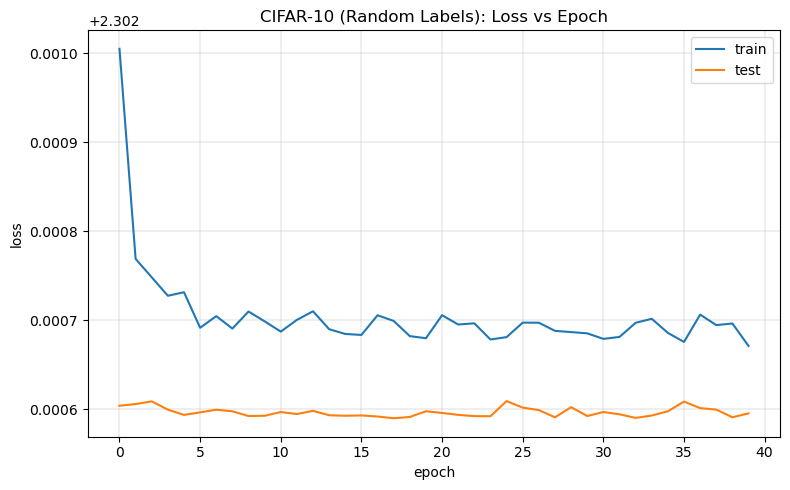

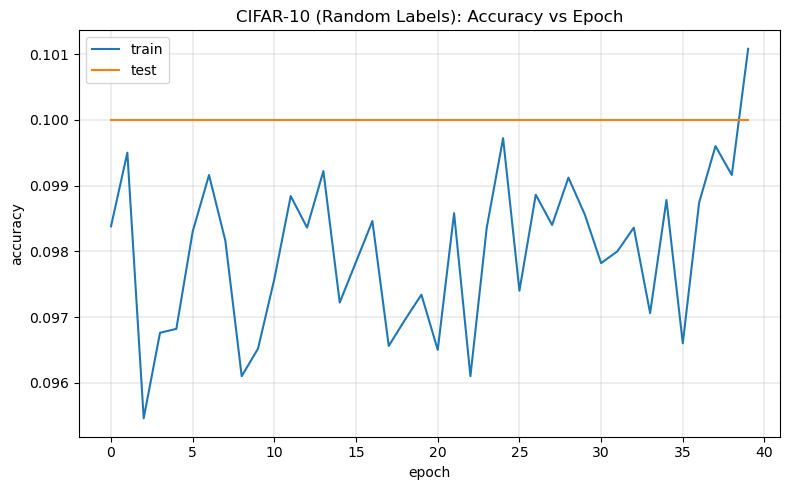

In [9]:
if __name__ == "__main__":
    main()